In [1]:
import sys
sys.path.insert(0,'C:\\Users\\nakaa1\\code\\PsychRNN')
sys.path.insert(0,'/Users/nakaa1/code/py/PsychRNN/')

import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
importlib.reload(psychrnn)

# from brian2 import *

<module 'psychrnn' from '/Users/nakaa1/code/py/PsychRNN/psychrnn/__init__.py'>

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [300]:
dt = 1 # time-step
tau = 20 # intrinsic time constant of neural state decay
T = 50 # time to run for (number of steps is T/dt)
N_batch = 30 # number of trials per training step
N_rec = 30 # number of recurrent units
name = 'basicModel'
N_in = 50
N_out = 50

In [301]:
from psychrnn.tasks.task import Task

def gaussian_input(N_in, mu = 0, sigma = 1):
    y = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (np.arange(N_in) - mu)**2 / (2 * sigma**2)))
    y = y/np.max(y)
    return y

"""
Binary Decision task. 
Takes two channels of noisy input.
Binary output with a one hot encoding towards the higher mean channel
"""

class noisy_decode(Task):
    
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(noisy_decode,self).__init__(N_in, N_out, dt, tau, T, N_batch)
        
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6 + T * 0.1
        params['duration'] = 20
        params['mu'] = np.random.randint(self.N_in)
        params['sigma'] = np.random.choice([3,4,5,6,7,8])
        params['neuron_noise'] = 2
        params['baseline_rate'] = 0
        params['peak_rate'] = np.random.choice(30)+5
        true_rates = gaussian_input(N_in = N_in,
                                              mu = params['mu'],
                                              sigma = params['sigma']) * params['peak_rate']
        true_rates[true_rates<0.01] = 0
        params['true_rates'] = true_rates.copy()
        params['N_input_dropout'] = 5
        params['input_drops'] = np.random.choice(self.N_in, size = params['N_input_dropout'], replace = False)
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) + params['baseline_rate'] + np.random.randn(self.N_in)*params['neuron_noise']
        y_t = np.zeros(self.N_out) + params['baseline_rate'] 
        mask_t = np.ones(self.N_out) 

        
        if (t>params['onset']) and (t<(params['onset']+params['duration'])):
            y_t += params['true_rates']
            x_t += params['true_rates']  
        for x in params['input_drops']:
            x_t[x] = 0
        x_t[x_t<0] = 0

        
        
        return x_t, y_t, mask_t


In [302]:
swv = noisy_decode(N_in = N_in, N_out = N_out,dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()

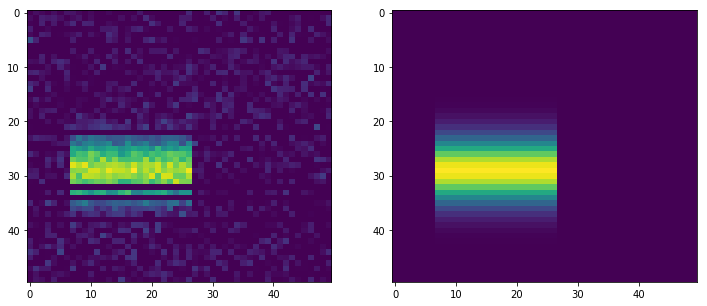

In [306]:
x,y,m = next(gen)
f,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].imshow(x[0,:,:].T,aspect = 'auto')
ax[1].imshow(y[0,:,:].T,aspect = 'auto')

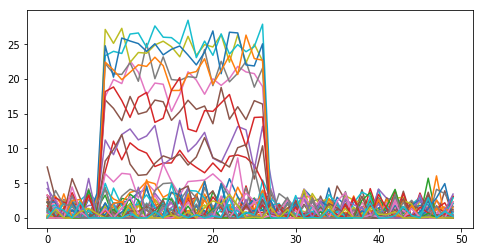

In [307]:
f,ax = plt.subplots(figsize = (8,4))
ax.plot(x[0,:,:]);
# ax.set_xlim((0,50))

In [308]:
params = swv.__dict__
print(params)

{'N_batch': 30, 'N_in': 50, 'N_out': 50, 'dt': 1, 'tau': 20, 'T': 50, 'alpha': 0.05, 'N_steps': 50}


There are some other optional parameters we can add in:

In [309]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec
params['dale_ratio'] = None # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0. # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = False # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
params['L2_out'] = 0.2
params['L2_rec'] = 0.2
params['L2_in'] = 0.2
params['L2_firing_rate_reg'] = 0.1
params['L1_out'] = 0.1
params['L1_in'] = 0.1
params['L1_rec'] = 0.1

In [310]:
try:
    basicModel.destruct()
except:
    pass
basicModel = Basic(params)
basicModel.build()

In [311]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 15000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 15000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x16ba92fd0>,
 'clip_grads': True}

In [312]:
basicModel.train(gen, train_params)

Iter 300, Minibatch Loss= 35.004074
Iter 600, Minibatch Loss= 33.321037
Iter 900, Minibatch Loss= 23.744617
Iter 1200, Minibatch Loss= 21.602062
Iter 1500, Minibatch Loss= 27.302780
Iter 1800, Minibatch Loss= 19.724091
Iter 2100, Minibatch Loss= 19.565952
Iter 2400, Minibatch Loss= 17.795473
Iter 2700, Minibatch Loss= 18.018330
Iter 3000, Minibatch Loss= 15.166357
Training weights saved in file: None100
Iter 3300, Minibatch Loss= 15.575990
Iter 3600, Minibatch Loss= 13.414788
Iter 3900, Minibatch Loss= 12.762853
Iter 4200, Minibatch Loss= 7.818631
Iter 4500, Minibatch Loss= 8.723485
Iter 4800, Minibatch Loss= 6.867166
Iter 5100, Minibatch Loss= 9.616826
Iter 5400, Minibatch Loss= 7.009983
Iter 5700, Minibatch Loss= 6.223206
Iter 6000, Minibatch Loss= 5.386604
Training weights saved in file: None200
Iter 6300, Minibatch Loss= 6.738818
Iter 6600, Minibatch Loss= 6.271665
Iter 6900, Minibatch Loss= 5.635380
Iter 7200, Minibatch Loss= 5.863002
Iter 7500, Minibatch Loss= 4.479491
Iter 7800,

([35.004074,
  33.321037,
  23.744617,
  21.602062,
  27.30278,
  19.72409,
  19.565952,
  17.795473,
  18.01833,
  15.166357,
  15.57599,
  13.414788,
  12.762853,
  7.818631,
  8.723485,
  6.8671656,
  9.616826,
  7.009983,
  6.2232056,
  5.386604,
  6.7388177,
  6.2716646,
  5.63538,
  5.863002,
  4.4794908,
  6.5365443,
  4.5560904,
  6.764382,
  5.3859673,
  6.2505846,
  5.6285486,
  5.1984396,
  5.4213943,
  4.776277,
  5.2979274,
  4.0021515,
  5.227256,
  3.6242175,
  4.5143027,
  4.8550234,
  4.149943,
  4.0867095,
  4.193561,
  4.9936037,
  4.2462206,
  4.397442,
  3.6629045,
  4.3029437,
  3.104064],
 38.4335150718689,
 4.440980911254883)

In [313]:
x,y,m = next(gen)
results = basicModel.test(x)
output = results[0]
state_var = results[1]

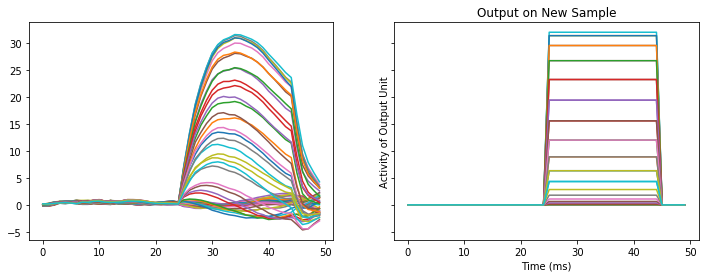

In [314]:
i = 4
f,ax = plt.subplots(1,2,figsize = (12,4),sharey = True, sharex = True)
ax[0].plot(range(0, len(output[i,:,:])*dt,dt),output[i,:,:]);
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")
ax[1].plot(range(0, len(y[i,:,:])*dt,dt), y[i,:,:]);

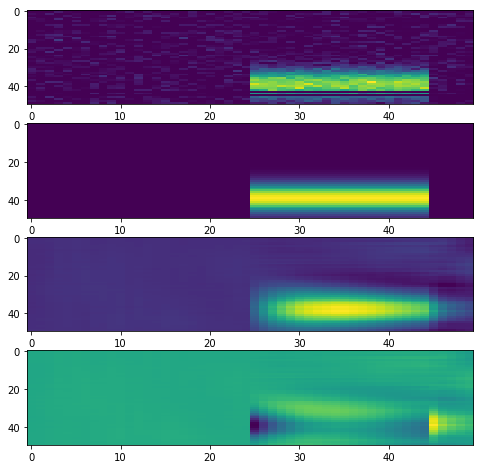

In [324]:
i = 4
f,ax = plt.subplots(4,1,figsize = (8,8))
ax[0].imshow(x[i,:,:].T,aspect = 'auto');
ax[1].imshow(y[i,:,:].T,aspect = 'auto');
ax[2].imshow(output[i,:,:].T,aspect = 'auto');
ax[3].imshow(output[i,:,:].T-y[i,:,:].T,aspect = 'auto');

In [316]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0

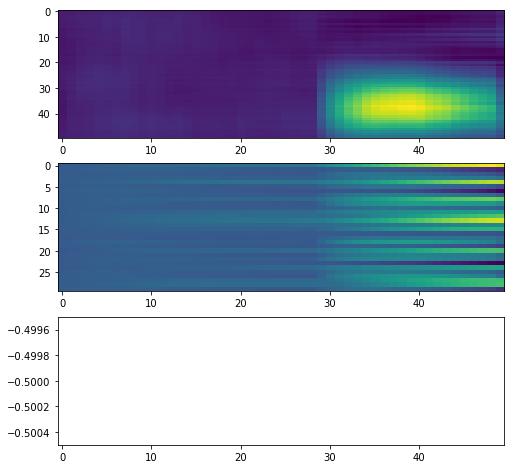

In [317]:
i = 17
f,ax = plt.subplots(3,1,figsize = (8,8))
ax[0].imshow(output[i,:,:].T,aspect = 'auto');
ax[1].imshow(state_var[i,:,E],aspect = 'auto');
ax[2].imshow(state_var[i,:,I],aspect = 'auto');

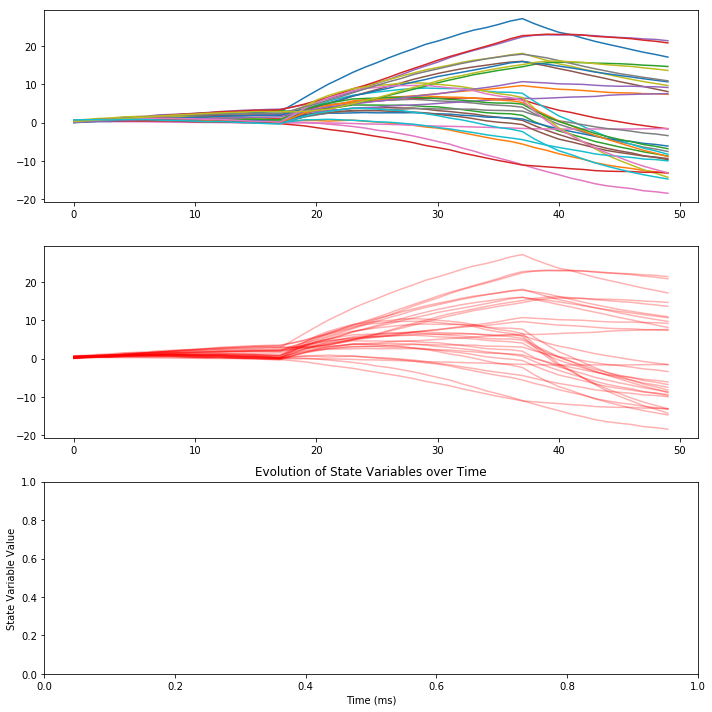

In [319]:
i = 8
f,ax = plt.subplots(3,1,figsize = (10,10))

ax[0].plot(range(0, len(state_var[i,:,:])*dt,dt),state_var[i,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

In [320]:
weights.keys()
toplot = ['W_in', 'W_rec', 
 'W_out','Dale_rec', 
 'Dale_out', 'input_connectivity', 
 'rec_connectivity', 'output_connectivity']

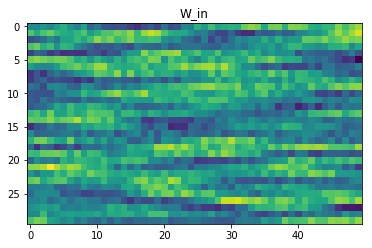

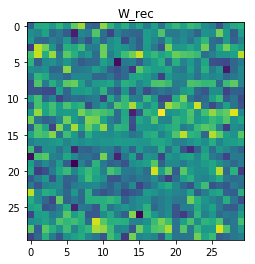

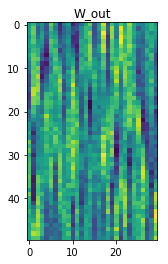

In [321]:
toplot = ['W_in', 'W_rec', 
 'W_out']
for key in toplot:
    plt.figure()
    plt.imshow(weights[key])
    plt.title(key)

In [322]:
import scipy.cluster.hierarchy as spc

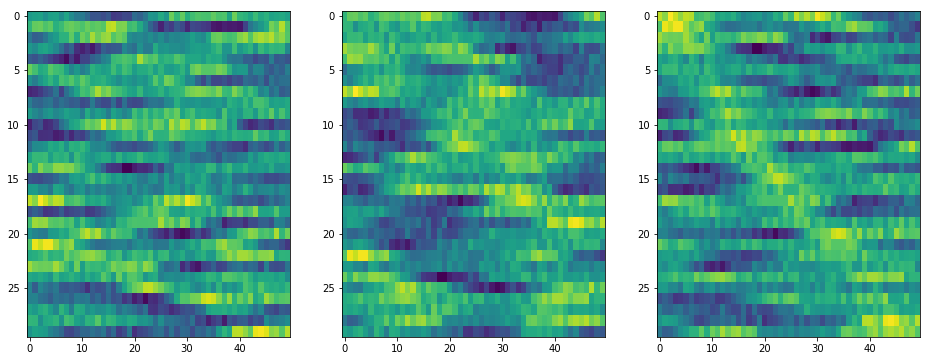

In [323]:
this_W = weights['W_in'][E,:]
this_W = weights['W_out'][:,E].T
corr = np.corrcoef(this_W)
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
max_idx = np.argsort(np.argmax(this_W,axis = 1))
f,ax = plt.subplots(1,3,figsize = (16,6))
ax[0].imshow(this_W,aspect = 'auto')
ax[1].imshow(this_W[corr_idx,:],aspect = 'auto')
ax[2].imshow(this_W[max_idx,:],aspect = 'auto')

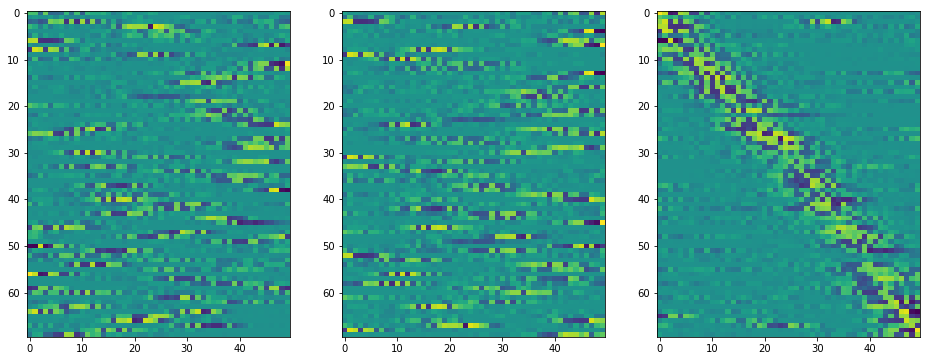

In [ ]:




corr = df.corr().values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

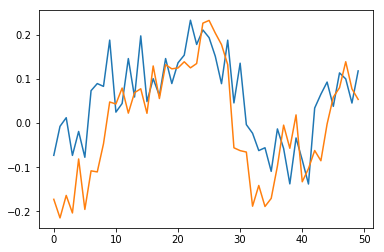

In [279]:
i = 8
plt.plot(weights['W_in'][i,:])
plt.plot(weights['W_out'][:,i])

In [63]:
N_rec = 10
dale_ratio = 0.8

In [64]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [65]:
dale_rec

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

Text(0.5, 1.0, 'Evolution of State Variables over Time')

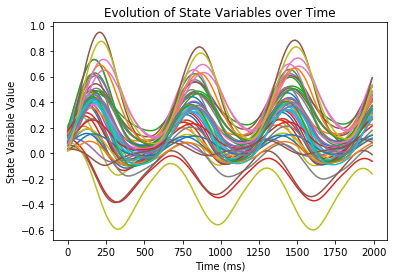

Clean up the model to clear out the tensorflow namespace

In [122]:
basicModel.destruct()

In [ ]:
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,T,dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,T,dt)
        psth = np.ones(time_bins.shape)*dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

def diff_of_exps(x_range,tau_rise = 1,tau_decay = 3, onset = 0):
    y = np.zeros(x_range.shape)
    for i,x in enumerate(x_range):
        y[i] = (1/np.exp((x-onset)/tau_decay)) - (1/np.exp((x-onset)/tau_rise))
    y[y<0] = 0
    return y 
#     onset_time = int(kernel_length*onset)
alpha_k = diff_of_exps(np.arange(30),tau_rise = 0.1,tau_decay = 3, onset = 14)   
plt.plot(np.arange(30),alpha_k)